In [3]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pylab as plt
%matplotlib inline
from scipy.stats import binned_statistic

In [2]:
conn = sqlite3.connect('../baseline/baseline_2snapsv1.4_10yrs.db')
df = pd.read_sql('select night,filter from summaryallprops;', conn)
conn.close

<function Connection.close>

In [6]:
bins=np.arange(-1, df['night'].max()+1, 1)+0.5
n_obs, be, bn = binned_statistic(df['night'], df['night'], bins=bins, statistic=np.size)

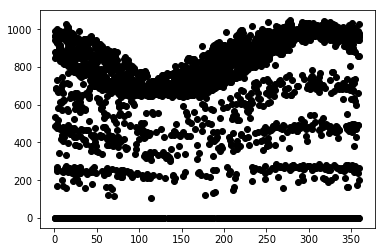

In [11]:
plt.plot(bins[1:] % 360, n_obs, 'ko')

In [17]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [18]:
rm = running_mean(n_obs, 7)

In [20]:
plt.plot()

3681